## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

In [3]:
# !wget $data

In [4]:
df = pd.read_csv("./data.csv")

In [5]:
selected_columns = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP"
]

df = df[selected_columns]

In [6]:
df["price"] = df["MSRP"]
del df["MSRP"]

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [8]:
df = df.fillna(0)
mean_price = df['price'].mean()
df['above_average'] = (df['price'] > mean_price).astype(int)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500,0


In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [11]:
df_full_train = df_full_train.reset_index(drop=True)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = df_train["above_average"].values
y_val = df_val["above_average"].values
y_test = df_test["above_average"].values

del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

## Q1

### Feature importance: ROC AUC score

In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
numerical = [col for col, dtype in df_train.dtypes.items() if dtype in ['int64', 'float64']]
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'price']

In [16]:
numerical.remove("price")

In [17]:
print("feature", "roc-auc_score")
for col in numerical:
    score = roc_auc_score(y_train, df_train[col])
    print(col, score)

feature roc-auc_score
year 0.687551492804683
engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.3669412128227987
city_mpg 0.3265755356754767


Answer: engine_hp

## Q2

### One-hot encoding

In [22]:
from sklearn.feature_extraction import DictVectorizer

In [23]:
dv = DictVectorizer(sparse=False)

In [24]:
categorical = [col for col, dtype in df.dtypes.items() if dtype == 'object']
categorical

['make', 'model', 'transmission_type', 'vehicle_style']

In [25]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

### Logistic regression training

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [28]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [29]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.6563698 , 0.00618931, 0.36653826, ..., 0.00405607, 0.99999003,
       0.06583963])

In [30]:
roc_auc_score(y_val, y_pred)

0.9803867466832218

In [31]:
from sklearn.metrics import roc_curve

In [32]:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9227068199786692

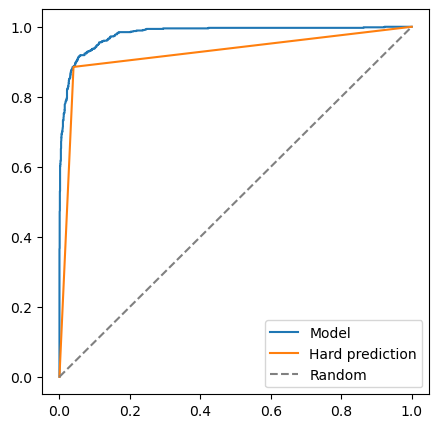

In [33]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='Model')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='Hard prediction')

plt.plot([0, 1], [0, 1], label='Random', color='grey', linestyle='--')

plt.legend()
plt.show()

Answer: 0.980

## Q3

### Confusion matrix

In [34]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [35]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [36]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [37]:
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r,f1
0,0.0,654,1729,0,0,0.274444,1.000000,0.430688
10,0.1,644,327,10,1402,0.663234,0.984709,0.792615
20,0.2,625,203,29,1526,0.754831,0.955657,0.843455
30,0.3,609,147,45,1582,0.805556,0.931193,0.863830
40,0.4,593,90,61,1639,0.868228,0.906728,0.887061
50,0.5,579,69,75,1660,0.893519,0.885321,0.889401
60,0.6,554,46,100,1683,0.923333,0.847095,0.883573
70,0.7,507,26,147,1703,0.951220,0.775229,0.854254
80,0.8,457,14,197,1715,0.970276,0.698777,0.812444
90,0.9,366,3,288,1726,0.991870,0.559633,0.715543


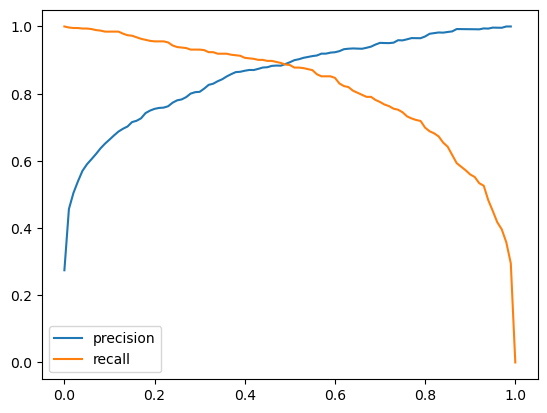

In [38]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

Answer: ~= 0.50

## Q4

### F1 score

In [39]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

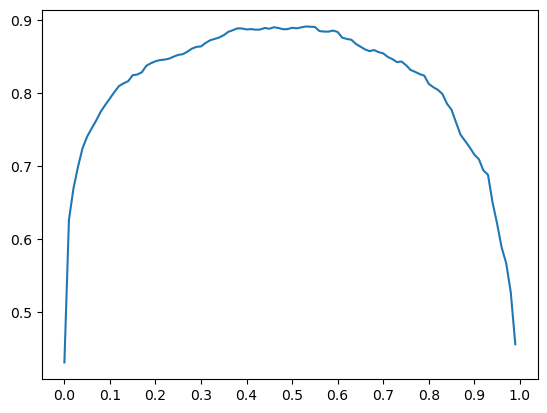

In [40]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Answer: ~= 0.50

## Q5

### Cross validation

In [55]:
from sklearn.model_selection import KFold

In [56]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [57]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train["above_average"]
    y_val = df_val["above_average"]

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.002


## Q6

## Hyperparemeter Tuning

In [58]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train["above_average"]
        y_val = df_val["above_average"]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C= 0.5, 0.977 +- 0.001
C=  10, 0.983 +- 0.003
